# Deep Reinforcement Learning - Assignment 1
## Training and Testing Q Learning and DQN Agents on FrozenLake-v1 and CartPole-v1

This notebook train and evaluate the agents as specified in the assignment requirements.

### Assignment Structure:
- **Section 1**: Q-Learning Agent (Tabular)
- **Section 2**: Deep Q-Learning Agent (DQN) - Basic Implementation
- **Section 3**: Improved Deep Q-Learning Agent (Double DQN + Dueling Architecture)

---

## Setup and Imports

Import necessary libraries and modules.

In [1]:
# Setup: Add project root to Python path
import os
import sys

# Get the notebook's directory
notebook_dir = os.path.abspath('')
project_root = notebook_dir  # Since notebook is in project root

# Add to path if not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"Python path updated: {project_root in sys.path}")

Project root: c:\Users\yonat\CodeProjects\DRL\Assignment1
Python path updated: True


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any, List
from datetime import datetime

# Gymnasium for CartPole environment
import gymnasium as gym

# PyTorch
import torch

# Disable PyTorch 2.0+ compilation features that might cause issues
torch._dynamo.config.suppress_errors = True
import torch._dynamo
torch._dynamo.disable()

# Force complete module reload - clear ALL cached imports
import sys
# Remove any agent-related modules
modules_to_remove = [key for key in list(sys.modules.keys()) 
                    if 'agent' in key.lower() or 'src' in key or 'utils' in key or 'ffnn' in key]
for module in modules_to_remove:
    del sys.modules[module]
    print(f"Removed cached module: {module}")

# NOW import our custom agents from src module
from src import (
    QLearningAgent,
    DeepQLearningAgent,
    DoubleDeepQLearningAgent
)

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Gymnasium version: {gym.__version__}")

# Verify we're using the correct module
print(f"\nAgent module location: {QLearningAgent.__module__}")

Removed cached module: _distutils_hack
Removed cached module: zmq.utils
Removed cached module: zmq.utils.interop
Removed cached module: zmq.utils.jsonapi
Removed cached module: asyncio.windows_utils
Removed cached module: traitlets.utils
Removed cached module: traitlets.utils.bunch
Removed cached module: traitlets.utils.descriptions
Removed cached module: traitlets.utils.getargspec
Removed cached module: traitlets.utils.importstring
Removed cached module: traitlets.utils.sentinel
Removed cached module: traitlets.utils.warnings
Removed cached module: traitlets.utils.decorators
Removed cached module: jupyter_core.utils
Removed cached module: traitlets.utils.text
Removed cached module: traitlets.utils.nested_update
Removed cached module: jupyter_client.utils
Removed cached module: executing._utils
Removed cached module: executing._pytest_utils
Removed cached module: pure_eval.utils
Removed cached module: stack_data.utils
Removed cached module: IPython.utils
Removed cached module: IPython.

## Helper Functions

Utility functions for visualization and analysis.

In [3]:
def plot_training_metrics(results: Dict[str, Any], agent_name: str, save_path: str = None):
    """
    Plot training metrics: rewards and losses.
    
    Args:
        results: Dictionary containing 'rewards', 'lengths', 'losses'
        agent_name: Name of the agent for plot title
        save_path: Optional path to save the figure
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Episode Rewards
    episodes = np.arange(1, len(results['rewards']) + 1)
    rewards = results['rewards']
    
    axes[0].plot(episodes, rewards, alpha=0.6, linewidth=0.8, label='Episode Reward')
    
    # Add moving average
    window = 100
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        axes[0].plot(np.arange(window, len(rewards) + 1), moving_avg, 
                    color='red', linewidth=2, label=f'{window}-Episode Moving Avg')
        
        # Add horizontal line at 475 (target)
        axes[0].axhline(y=475, color='green', linestyle='--', linewidth=2, 
                       label='Target (475.0)', alpha=0.7)
    
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Total Reward')
    axes[0].set_title(f'{agent_name}: Episode Rewards During Training')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Training Loss
    if results['losses']:
        training_steps = np.arange(1, len(results['losses']) + 1)
        losses = results['losses']
        
        axes[1].plot(training_steps, losses, alpha=0.6, linewidth=0.8, color='orange')
        
        # Add moving average for loss
        if len(losses) >= window:
            loss_moving_avg = np.convolve(losses, np.ones(window)/window, mode='valid')
            axes[1].plot(np.arange(window, len(losses) + 1), loss_moving_avg, 
                        color='red', linewidth=2, label=f'{window}-Step Moving Avg')
        
        axes[1].set_xlabel('Training Step')
        axes[1].set_ylabel('Loss')
        axes[1].set_title(f'{agent_name}: Training Loss')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No loss data available', 
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title(f'{agent_name}: Training Loss')
    
    plt.tight_layout()
    
    if save_path:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    plt.show()


def find_convergence_episode(rewards: List[float], target: float = 475.0, window: int = 100) -> int:
    """
    Find the first episode where the agent achieves target average reward.
    
    Args:
        rewards: List of episode rewards
        target: Target average reward (default: 475.0)
        window: Window size for computing average (default: 100)
    
    Returns:
        Episode number (1-indexed) or -1 if target not reached
    """
    if len(rewards) < window:
        return -1
    
    for i in range(window - 1, len(rewards)):
        avg_reward = np.mean(rewards[i - window + 1:i + 1])
        if avg_reward >= target:
            return i + 1  # Return 1-indexed episode number
    
    return -1


def print_convergence_info(results: Dict[str, Any], agent_name: str):
    """Print convergence information."""
    convergence_ep = find_convergence_episode(results['rewards'])
    
    print(f"\n{'='*60}")
    print(f"CONVERGENCE ANALYSIS: {agent_name}")
    print(f"{'='*60}")
    
    if convergence_ep > 0:
        print(f"✓ Agent converged at episode: {convergence_ep}")
        print(f"  (First episode where 100-episode average ≥ 475.0)")
        
        # Show final performance
        final_100_avg = np.mean(results['rewards'][-100:])
        print(f"\nFinal Performance (last 100 episodes):")
        print(f"  Average Reward: {final_100_avg:.2f}")
        print(f"  Max Reward: {np.max(results['rewards'][-100:]):.2f}")
        print(f"  Min Reward: {np.min(results['rewards'][-100:]):.2f}")
    else:
        print(f"✗ Agent did not converge to 475.0 average within training")
        if len(results['rewards']) >= 100:
            best_100_avg = max([np.mean(results['rewards'][i:i+100]) 
                               for i in range(len(results['rewards']) - 99)])
            print(f"  Best 100-episode average achieved: {best_100_avg:.2f}")
    
    print(f"{'='*60}\n")


def save_model_and_results(agent, results: Dict[str, Any], agent_name: str, base_dir: str = "models"):
    """Save trained model and results."""
    os.makedirs(base_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save model
    model_path = os.path.join(base_dir, f"{agent_name}_{timestamp}.pth")
    agent.save(model_path)
    
    # Save results
    results_path = os.path.join(base_dir, f"{agent_name}_{timestamp}_results.npz")
    np.savez(results_path, 
             rewards=results['rewards'],
             lengths=results['lengths'],
             losses=results['losses'])
    
    print(f"✓ Model saved to: {model_path}")
    print(f"✓ Results saved to: {results_path}")


def generate_training_summary(results, config, agent_name="Q-Learning"):
    """Generate detailed training summary statistics."""
    rewards = results['rewards']
    lengths = results['lengths']
    num_episodes = len(rewards)
    
    successes = [1 if r > 0 else 0 for r in rewards]
    
    phases = {
        'Initial Exploration (1-1000)': (0, 1000),
        'Learning Phase (1001-3000)': (1000, 3000),
        'Refinement Phase (3001-5000)': (3000, 5000),
        'Convergence Phase (5001-end)': (5000, num_episodes)
    }
    
    summary = []
    summary.append("="*70)
    summary.append(f"TRAINING SUMMARY: {agent_name}")
    summary.append("="*70)
    summary.append(f"\nConfiguration:")
    summary.append(f"  Alpha (α): {config['alpha']}")
    summary.append(f"  Gamma (γ): {config['gamma']}")
    summary.append(f"  Epsilon Decay: {config['epsilon_decay']}")
    summary.append(f"  Episodes: {num_episodes}")
    
    summary.append(f"\n{'='*70}")
    summary.append("PERFORMANCE BY TRAINING PHASE:")
    summary.append("="*70)
    
    for phase_name, (start, end) in phases.items():
        if end > num_episodes:
            end = num_episodes
        phase_rewards = rewards[start:end]
        phase_lengths = lengths[start:end]
        phase_successes = successes[start:end]
        
        if len(phase_rewards) > 0:
            success_rate = np.mean(phase_successes)
            avg_reward = np.mean(phase_rewards)
            avg_length = np.mean(phase_lengths)
            
            summary.append(f"\n{phase_name}:")
            summary.append(f"  Success Rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
            summary.append(f"  Average Reward: {avg_reward:.3f}")
            summary.append(f"  Average Steps: {avg_length:.2f}")
    
    if num_episodes >= 100:
        final_rewards = rewards[-100:]
        final_successes = successes[-100:]
        final_lengths = lengths[-100:]
        
        summary.append(f"\n{'='*70}")
        summary.append("FINAL 100 EPISODES:")
        summary.append("="*70)
        summary.append(f"  Success Rate: {np.mean(final_successes):.3f} ({np.mean(final_successes)*100:.1f}%)")
        summary.append(f"  Average Reward: {np.mean(final_rewards):.3f}")
        summary.append(f"  Average Steps: {np.mean(final_lengths):.2f}")
        summary.append(f"  Best Reward: {np.max(final_rewards):.3f}")
        summary.append(f"  Worst Reward: {np.min(final_rewards):.3f}")
    
    summary.append("="*70)
    
    summary_text = "\n".join(summary)
    print(summary_text)
    
    os.makedirs("results/section1", exist_ok=True)
    with open(f"results/section1/training_summary_{agent_name.lower().replace(' ', '_')}.txt", "w", encoding='utf-8') as f:
        f.write(summary_text)
    
    return summary_text


def extract_policy_from_q_table(q_table):
    """Extract policy from Q-table."""
    policy = np.argmax(q_table, axis=1)
    values = np.max(q_table, axis=1)
    return policy, values


def visualize_policy_grid(policy, values, title="Learned Policy"):
    """Visualize policy as a 4x4 grid with arrows."""
    actions = ['←', '↓', '→', '↑']
    
    policy_grid = policy.reshape(4, 4)
    value_grid = values.reshape(4, 4)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Policy with arrows
    im1 = axes[0].imshow(value_grid, cmap='RdYlGn', alpha=0.6)
    for i in range(4):
        for j in range(4):
            state_idx = i * 4 + j
            action = policy[state_idx]
            value = values[state_idx]
            
            axes[0].text(j, i, actions[action], 
                        ha='center', va='center', 
                        fontsize=24, fontweight='bold')
            axes[0].text(j, i+0.35, f"{value:.2f}",
                        ha='center', va='center',
                        fontsize=9, color='black')
    
    axes[0].set_xticks(range(4))
    axes[0].set_yticks(range(4))
    axes[0].set_title(f'{title}\nPolicy (Arrows) and Values', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Column')
    axes[0].set_ylabel('Row')
    plt.colorbar(im1, ax=axes[0], label='State Value')
    
    # Value heatmap only
    im2 = axes[1].imshow(value_grid, cmap='RdYlGn')
    for i in range(4):
        for j in range(4):
            state_idx = i * 4 + j
            value = values[state_idx]
            axes[1].text(j, i, f"{value:.3f}",
                        ha='center', va='center',
                        fontsize=11, fontweight='bold')
    
    axes[1].set_xticks(range(4))
    axes[1].set_yticks(range(4))
    axes[1].set_title(f'{title}\nState Values', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Column')
    axes[1].set_ylabel('Row')
    plt.colorbar(im2, ax=axes[1], label='State Value')
    
    plt.tight_layout()
    plt.show()


def save_policy_to_file(q_table, filename="results/section1/policy_baseline.txt"):
    """Save policy in human-readable format."""
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    policy = np.argmax(q_table, axis=1)
    values = np.max(q_table, axis=1)
    actions = ['Left', 'Down', 'Right', 'Up']
    action_symbols = ['←', '↓', '→', '↑']
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("="*70 + "\n")
        f.write("LEARNED POLICY AND VALUE FUNCTION\n")
        f.write("="*70 + "\n\n")
        
        f.write("State | Value  | Policy | Grid Position\n")
        f.write("-"*70 + "\n")
        
        for state in range(16):
            row = state // 4
            col = state % 4
            f.write(f"  {state:2d}  | {values[state]:6.4f} | {actions[policy[state]]:6s} | ({row}, {col})\n")
        
        f.write("\n" + "="*70 + "\n")
        f.write("POLICY AS 4x4 GRID (← ↓ → ↑)\n")
        f.write("="*70 + "\n")
        
        for row in range(4):
            row_str = "  "
            for col in range(4):
                state = row * 4 + col
                row_str += action_symbols[policy[state]] + "  "
            f.write(row_str + "\n")
        
        f.write("\n" + "="*70 + "\n")
        f.write("VALUE FUNCTION AS 4x4 GRID\n")
        f.write("="*70 + "\n")
        
        for row in range(4):
            row_str = "  "
            for col in range(4):
                state = row * 4 + col
                row_str += f"{values[state]:6.3f}  "
            f.write(row_str + "\n")
        
        f.write("\n")
    
    print(f"✓ Policy saved to: {filename}")


def evaluate_qlearning_agent(agent, env, num_episodes: int = 100) -> tuple:
    """
    Evaluate the trained Q-Learning agent's performance.
    
    Args:
        agent: Trained QLearningAgent
        env: Gymnasium environment
        num_episodes: Number of evaluation episodes
        
    Returns:
        Tuple of (success_rate, avg_reward, avg_length)
    """
    successes = 0
    total_rewards = []
    episode_lengths = []
    
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        steps = 0
        
        while not done and steps < 100:  # Max 100 steps
            action = agent.select_action(state, training=False)  # Greedy
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            steps += 1
        
        if reward > 0:  # Goal reached
            successes += 1
        total_rewards.append(episode_reward)
        episode_lengths.append(steps)
    
    success_rate = successes / num_episodes
    avg_reward = np.mean(total_rewards)
    avg_length = np.mean(episode_lengths)
    
    return success_rate, avg_reward, avg_length


def visualize_q_table(q_table: np.ndarray, title: str = "Q-Table Heatmap"):
    """
    Visualize Q-table as heatmap.
    
    Args:
        q_table: Q-table array of shape (num_states, num_actions)
        title: Plot title
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    im = ax.imshow(q_table, cmap='RdYlGn', aspect='auto')
    
    # Labels
    ax.set_xlabel('Actions', fontsize=12)
    ax.set_ylabel('States', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Action labels
    actions = ['Left', 'Down', 'Right', 'Up']
    ax.set_xticks(range(len(actions)))
    ax.set_xticklabels(actions)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Q-Value', fontsize=11)
    
    plt.tight_layout()
    plt.show()


def plot_qlearning_results(results: Dict[str, Any], config_name: str):
    """
    Plot Q-Learning training results.
    
    Args:
        results: Dictionary with training metrics
        config_name: Name of configuration for title
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    rewards = results['rewards']
    lengths = results['lengths']
    episodes = np.arange(1, len(rewards) + 1)
    
    # Plot rewards with moving average
    window = 100
    axes[0].plot(episodes, rewards, alpha=0.3, linewidth=0.5, label='Episode Reward')
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        axes[0].plot(np.arange(window, len(rewards) + 1), moving_avg,
                    color='red', linewidth=2, label=f'{window}-Episode Moving Avg')
    
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Reward')
    axes[0].set_title(f'{config_name}: Training Rewards')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot episode lengths
    axes[1].plot(episodes, lengths, alpha=0.3, linewidth=0.5, label='Episode Length')
    if len(lengths) >= window:
        moving_avg = np.convolve(lengths, np.ones(window)/window, mode='valid')
        axes[1].plot(np.arange(window, len(lengths) + 1), moving_avg,
                    color='red', linewidth=2, label=f'{window}-Episode Moving Avg')
    
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Steps to Goal')
    axes[1].set_title(f'{config_name}: Episode Lengths')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

---
# Section 1: Q-Learning Agent (Tabular)

In this section, we implement and train a traditional Q-Learning agent on FrozenLake-v1.

## Requirements:
- Tabular Q-Learning with discrete state space
- Epsilon-greedy exploration
- Temporal Difference (TD) learning

## Analysis Tasks:
1. Test different hyperparameter configurations (alpha, gamma, epsilon_decay)
2. Find optimal configuration
3. Plot training rewards and Q-table evolution
4. Evaluate final policy success rate

## 1.1 Environment Setup: FrozenLake-v1

In [119]:
# Create FrozenLake environment
env_frozen = gym.make('FrozenLake-v1', is_slippery=True)

# Get environment dimensions
state_dim_frozen = env_frozen.observation_space.n
action_dim_frozen = env_frozen.action_space.n

print("FrozenLake-v1 Environment:")
print(f"  State dimension: {state_dim_frozen} (discrete)")
print(f"  Action dimension: {action_dim_frozen}")
print(f"  State space: {env_frozen.observation_space}")
print(f"  Action space: {env_frozen.action_space}")
print("\nGoal: Navigate from Start (S) to Goal (G) on slippery ice")
print("Map Layout:")
print("  S = Start, F = Frozen surface, H = Hole, G = Goal")

FrozenLake-v1 Environment:
  State dimension: 16 (discrete)
  Action dimension: 4
  State space: Discrete(16)
  Action space: Discrete(4)

Goal: Navigate from Start (S) to Goal (G) on slippery ice
Map Layout:
  S = Start, F = Frozen surface, H = Hole, G = Goal


## 1.2: Configuration 1: Baseline

### Setup

In [120]:
# Baseline configuration
config_baseline = {
    'alpha': 0.1,              # Learning rate
    'gamma': 0.95,             # Discount factor
    'epsilon_start': 1.0,      # Initial exploration
    'epsilon_min': 0.01,       # Minimum exploration
    'epsilon_decay': 0.995     # Exploration decay
}

# Create agent
agent_ql_baseline = QLearningAgent(
    state_dim=state_dim_frozen,
    action_dim=action_dim_frozen,
    config=config_baseline
)

print("Q-Learning Agent - Baseline Configuration:")
print(f"  Alpha (Learning Rate): {config_baseline['alpha']}")
print(f"  Gamma (Discount Factor): {config_baseline['gamma']}")
print(f"  Epsilon Start: {config_baseline['epsilon_start']}")
print(f"  Epsilon Min: {config_baseline['epsilon_min']}")
print(f"  Epsilon Decay: {config_baseline['epsilon_decay']}")

Q-Learning Agent - Baseline Configuration:
  Alpha (Learning Rate): 0.1
  Gamma (Discount Factor): 0.95
  Epsilon Start: 1.0
  Epsilon Min: 0.01
  Epsilon Decay: 0.995


### Train

In [121]:
# Training parameters
NUM_EPISODES_QL = 10000
MAX_STEPS_QL = 100
EVAL_FREQ_QL = 1000

print(f"Training Q-Learning agent (Baseline)...")
print(f"Episodes: {NUM_EPISODES_QL}")
print(f"Max steps per episode: {MAX_STEPS_QL}\n")

# Train
results_baseline = agent_ql_baseline.train_agent(
    env=env_frozen,
    max_episodes=NUM_EPISODES_QL,
    max_steps=MAX_STEPS_QL,
    eval_frequency=EVAL_FREQ_QL,
    verbose=True
)

print("\n✓ Training completed!")

Training Q-Learning agent (Baseline)...
Episodes: 10000
Max steps per episode: 100

Episode 1000/10000 | Avg Reward (=Length): 0.31 | Epsilon: 0.010
Episode 1000/10000 | Avg Reward (=Length): 0.31 | Epsilon: 0.010
Episode 2000/10000 | Avg Reward (=Length): 0.60 | Epsilon: 0.010
Episode 2000/10000 | Avg Reward (=Length): 0.60 | Epsilon: 0.010
Episode 3000/10000 | Avg Reward (=Length): 0.64 | Epsilon: 0.010
Episode 3000/10000 | Avg Reward (=Length): 0.64 | Epsilon: 0.010
Episode 4000/10000 | Avg Reward (=Length): 0.66 | Epsilon: 0.010
Episode 4000/10000 | Avg Reward (=Length): 0.66 | Epsilon: 0.010
Episode 5000/10000 | Avg Reward (=Length): 0.62 | Epsilon: 0.010
Episode 5000/10000 | Avg Reward (=Length): 0.62 | Epsilon: 0.010
Episode 6000/10000 | Avg Reward (=Length): 0.59 | Epsilon: 0.010
Episode 6000/10000 | Avg Reward (=Length): 0.59 | Epsilon: 0.010
Episode 7000/10000 | Avg Reward (=Length): 0.62 | Epsilon: 0.010
Episode 7000/10000 | Avg Reward (=Length): 0.62 | Epsilon: 0.010
Episod

### Evaluate


Baseline Configuration Performance:
  Success Rate: 0.640 (64%)
  Average Reward: 0.640
  Average Episode Length: 44.89 steps


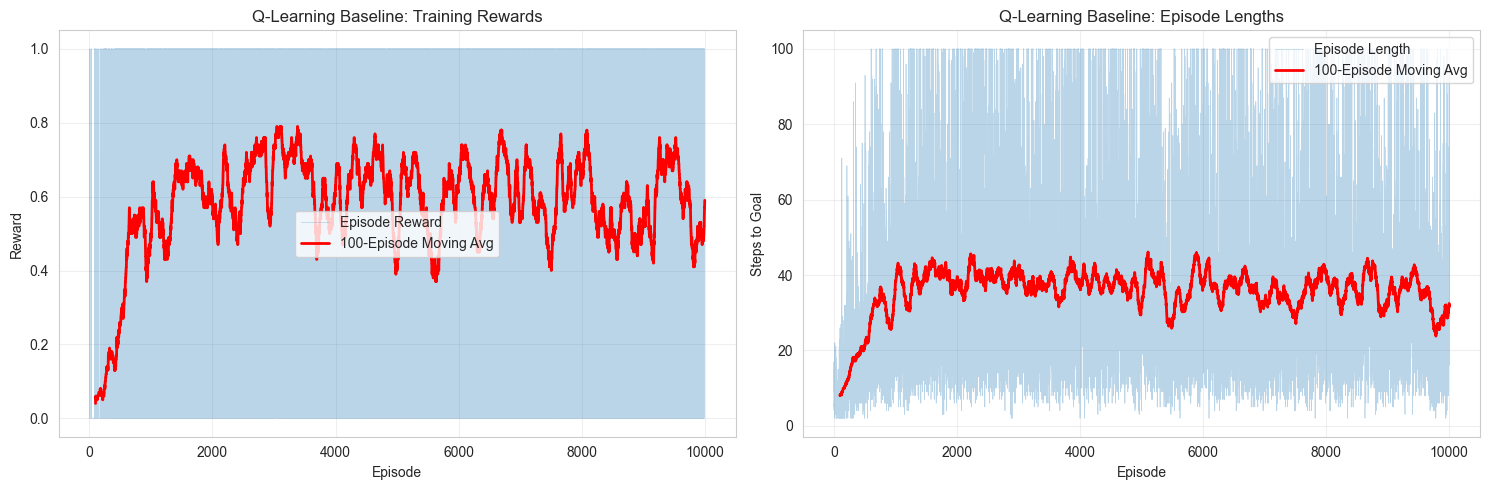


Q-Table Visualization:


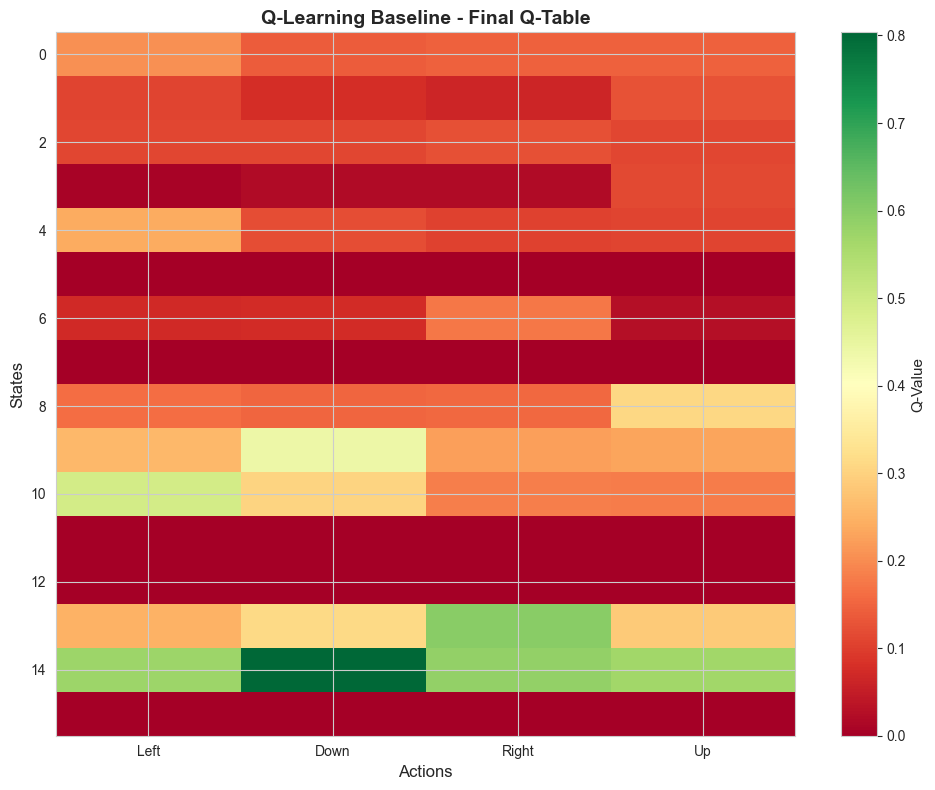

In [122]:
# Evaluate performance
success_rate, avg_reward, avg_length = evaluate_qlearning_agent(
    agent_ql_baseline, env_frozen, num_episodes=100
)

print(f"\nBaseline Configuration Performance:")
print(f"  Success Rate: {success_rate:.3f} ({int(success_rate*100)}%)")
print(f"  Average Reward: {avg_reward:.3f}")
print(f"  Average Episode Length: {avg_length:.2f} steps")

# Plot results
plot_qlearning_results(results_baseline, "Q-Learning Baseline")

# Visualize Q-table
print("\nQ-Table Visualization:")
visualize_q_table(agent_ql_baseline.q_table, "Q-Learning Baseline - Final Q-Table")

In [123]:
# Generate training summary
training_summary = generate_training_summary(results_baseline, config_baseline, "Baseline")

TRAINING SUMMARY: Baseline

Configuration:
  Alpha (α): 0.1
  Gamma (γ): 0.95
  Epsilon Decay: 0.995
  Episodes: 10000

PERFORMANCE BY TRAINING PHASE:

Initial Exploration (1-1000):
  Success Rate: 0.312 (31.2%)
  Average Reward: 0.312
  Average Steps: 23.57

Learning Phase (1001-3000):
  Success Rate: 0.618 (61.8%)
  Average Reward: 0.618
  Average Steps: 39.10

Refinement Phase (3001-5000):
  Success Rate: 0.639 (63.9%)
  Average Reward: 0.639
  Average Steps: 37.43

Convergence Phase (5001-end):
  Success Rate: 0.596 (59.6%)
  Average Reward: 0.596
  Average Steps: 35.88

FINAL 100 EPISODES:
  Success Rate: 0.590 (59.0%)
  Average Reward: 0.590
  Average Steps: 31.94
  Best Reward: 1.000
  Worst Reward: 0.000


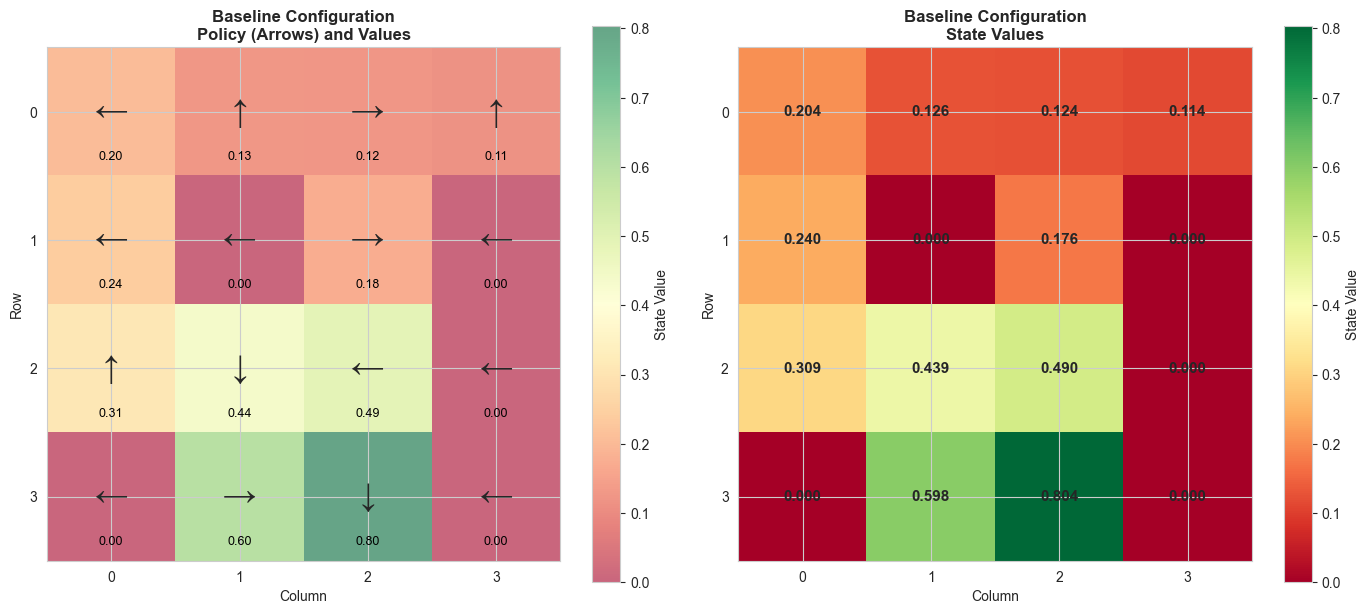

In [124]:
# Extract and visualize policy
policy, values = extract_policy_from_q_table(agent_ql_baseline.q_table)
visualize_policy_grid(policy, values, "Baseline Configuration")

## 1.3 Configuration 2: Higher Learning Rate

Q-Learning Agent - High Learning Rate:
  Alpha: 0.3 (vs baseline 0.1)

High Learning Rate Performance:
  Success Rate: 0.530
  Average Reward: 0.530

High Learning Rate Performance:
  Success Rate: 0.530
  Average Reward: 0.530


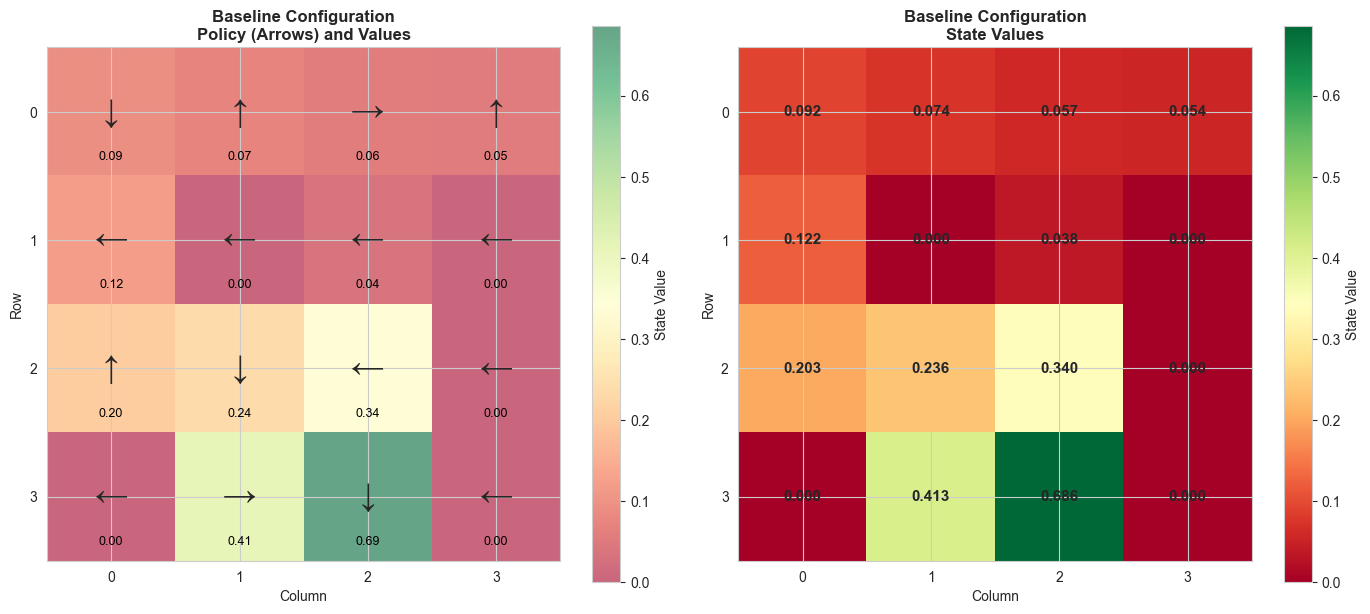

In [113]:
# Higher learning rate configuration
config_high_lr = {
    'alpha': 0.3,              # Higher learning rate
    'gamma': 0.95,
    'epsilon_start': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.995
}

agent_ql_high_lr = QLearningAgent(
    state_dim=state_dim_frozen,
    action_dim=action_dim_frozen,
    config=config_high_lr
)

print("Q-Learning Agent - High Learning Rate:")
print(f"  Alpha: {config_high_lr['alpha']} (vs baseline {config_baseline['alpha']})")

# Train
results_high_lr = agent_ql_high_lr.train_agent(
    env=env_frozen,
    max_episodes=NUM_EPISODES_QL,
    max_steps=MAX_STEPS_QL,
    eval_frequency=EVAL_FREQ_QL,
    verbose=False
)

# Evaluate
success_rate_hlr, avg_reward_hlr, avg_length_hlr = evaluate_qlearning_agent(
    agent_ql_high_lr, env_frozen, num_episodes=100
)

print(f"\nHigh Learning Rate Performance:")
print(f"  Success Rate: {success_rate_hlr:.3f}")
print(f"  Average Reward: {avg_reward_hlr:.3f}")

# Extract and visualize policy
policy, values = extract_policy_from_q_table(agent_ql_high_lr.q_table)
visualize_policy_grid(policy, values, "Baseline Configuration")

## 1.4 Configuration 3: Slower Exploration Decay

Q-Learning Agent - Slow Exploration Decay:
  Epsilon Decay: 0.999 (vs baseline 0.995)

Slow Decay Performance:
  Success Rate: 0.720
  Average Reward: 0.720

Slow Decay Performance:
  Success Rate: 0.720
  Average Reward: 0.720


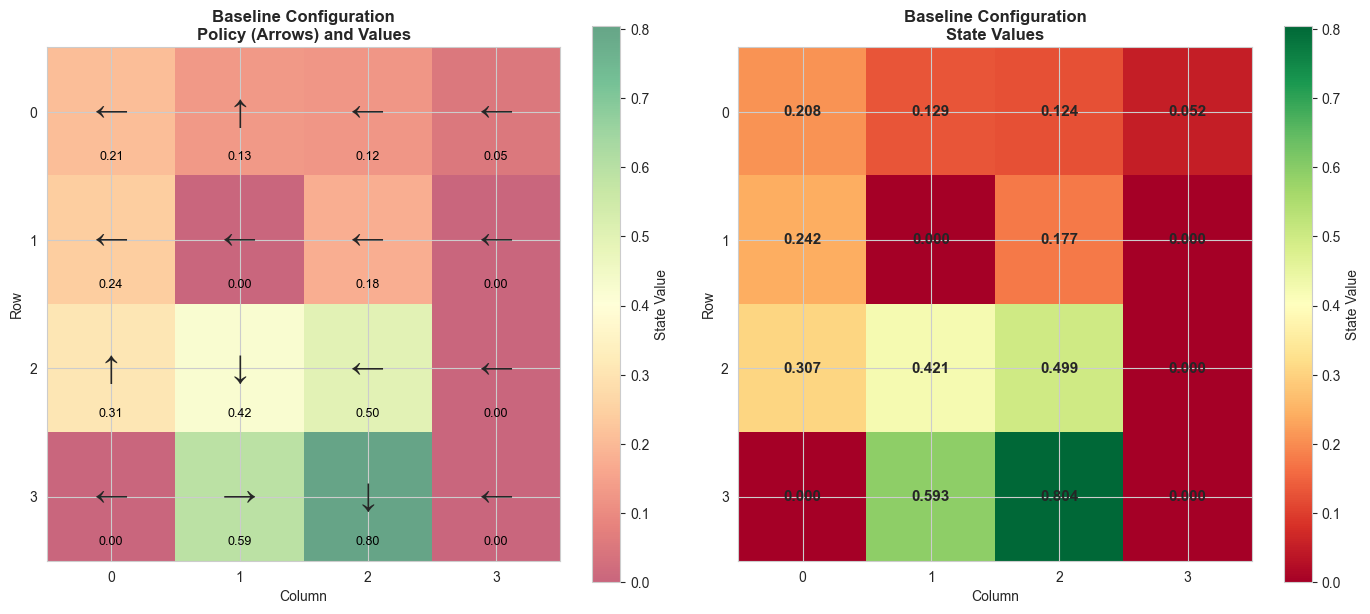

In [114]:
# Slower epsilon decay configuration
config_slow_decay = {
    'alpha': 0.1,
    'gamma': 0.95,
    'epsilon_start': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.999      # Slower decay
}

agent_ql_slow_decay = QLearningAgent(
    state_dim=state_dim_frozen,
    action_dim=action_dim_frozen,
    config=config_slow_decay
)

print("Q-Learning Agent - Slow Exploration Decay:")
print(f"  Epsilon Decay: {config_slow_decay['epsilon_decay']} (vs baseline {config_baseline['epsilon_decay']})")

# Train
results_slow_decay = agent_ql_slow_decay.train_agent(
    env=env_frozen,
    max_episodes=NUM_EPISODES_QL,
    max_steps=MAX_STEPS_QL,
    eval_frequency=EVAL_FREQ_QL,
    verbose=False
)

# Evaluate
success_rate_sd, avg_reward_sd, avg_length_sd = evaluate_qlearning_agent(
    agent_ql_slow_decay, env_frozen, num_episodes=100
)

print(f"\nSlow Decay Performance:")
print(f"  Success Rate: {success_rate_sd:.3f}")
print(f"  Average Reward: {avg_reward_sd:.3f}")

# Extract and visualize policy
policy, values = extract_policy_from_q_table(agent_ql_slow_decay.q_table)
visualize_policy_grid(policy, values, "Baseline Configuration")

## 1.5 Compare all


Q-LEARNING CONFIGURATION COMPARISON
     Configuration  Alpha  Epsilon Decay  Success Rate  Avg Reward  Avg Length
          Baseline    0.1          0.995          0.66        0.66       34.15
High Learning Rate    0.3          0.995          0.53        0.53       28.08
        Slow Decay    0.1          0.999          0.72        0.72       39.31



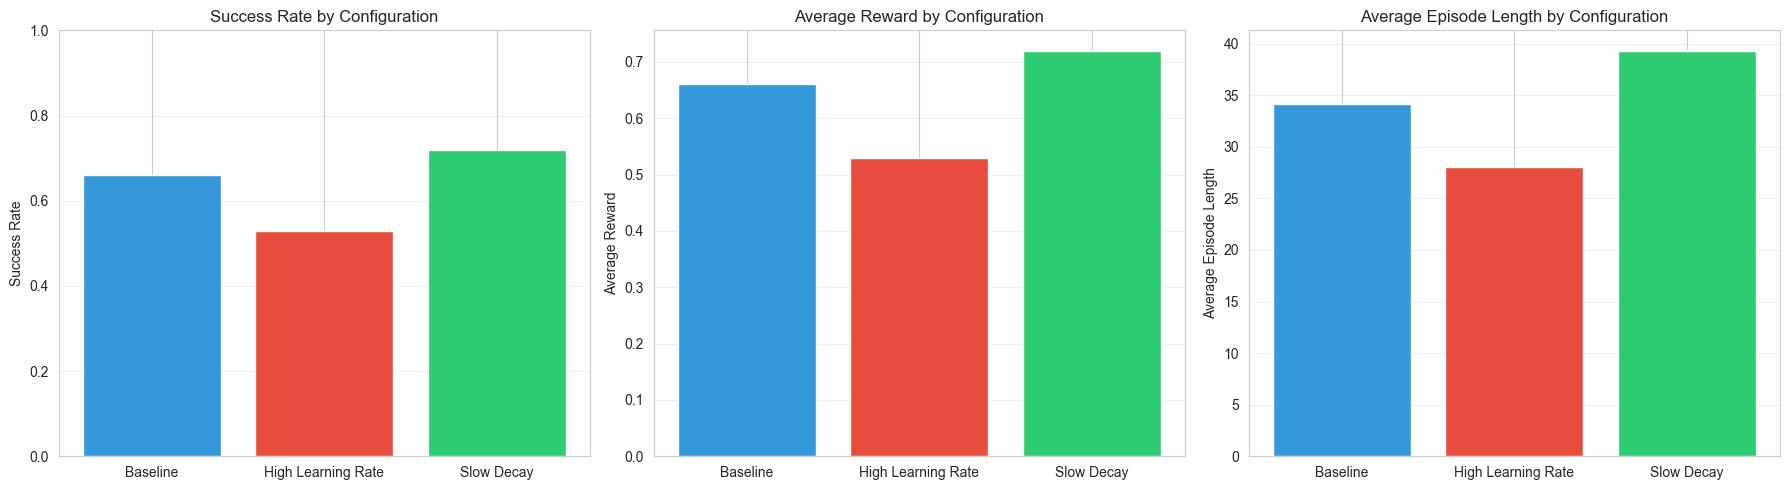

✓ Comparison plot saved to: results/section1/qlearning_comparison.png


In [115]:
# Comparison table
comparison_data = {
    'Configuration': ['Baseline', 'High Learning Rate', 'Slow Decay'],
    'Alpha': [config_baseline['alpha'], config_high_lr['alpha'], config_slow_decay['alpha']],
    'Epsilon Decay': [config_baseline['epsilon_decay'], config_high_lr['epsilon_decay'], config_slow_decay['epsilon_decay']],
    'Success Rate': [success_rate, success_rate_hlr, success_rate_sd],
    'Avg Reward': [avg_reward, avg_reward_hlr, avg_reward_sd],
    'Avg Length': [avg_length, avg_length_hlr, avg_length_sd]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("Q-LEARNING CONFIGURATION COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80 + "\n")

# Bar plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

configs = comparison_df['Configuration']
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Success Rate
axes[0].bar(configs, comparison_df['Success Rate'], color=colors)
axes[0].set_ylabel('Success Rate')
axes[0].set_title('Success Rate by Configuration')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')

# Average Reward
axes[1].bar(configs, comparison_df['Avg Reward'], color=colors)
axes[1].set_ylabel('Average Reward')
axes[1].set_title('Average Reward by Configuration')
axes[1].grid(True, alpha=0.3, axis='y')

# Average Length
axes[2].bar(configs, comparison_df['Avg Length'], color=colors)
axes[2].set_ylabel('Average Episode Length')
axes[2].set_title('Average Episode Length by Configuration')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("results/section1/qlearning_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Comparison plot saved to: results/section1/qlearning_comparison.png")

## 1.6 Q-Table Evaluation Plots

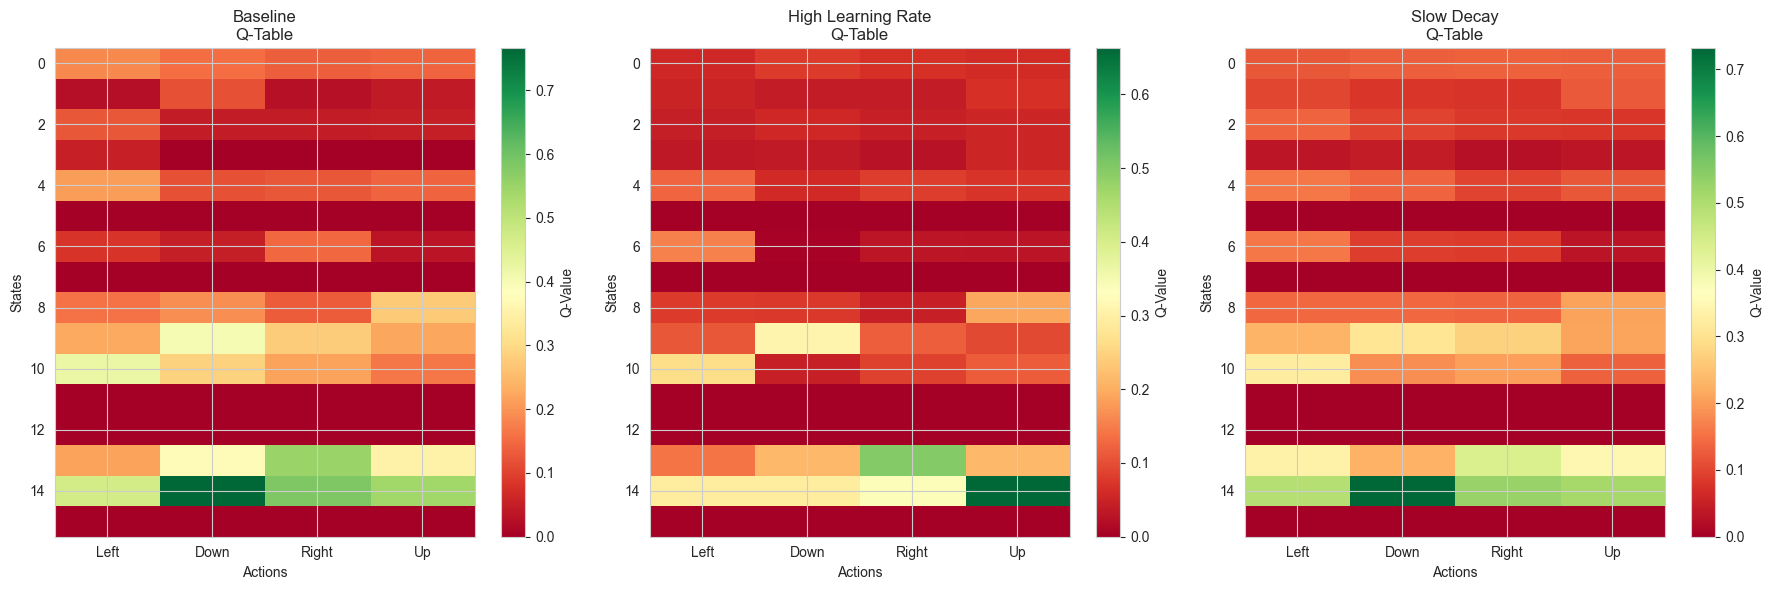

✓ Q-table comparison saved to: results/section1/qtable_comparison.png


In [108]:
# Compare Q-tables
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

q_tables = [
    (agent_ql_baseline.q_table, 'Baseline'),
    (agent_ql_high_lr.q_table, 'High Learning Rate'),
    (agent_ql_slow_decay.q_table, 'Slow Decay')
]

for idx, (q_table, name) in enumerate(q_tables):
    im = axes[idx].imshow(q_table, cmap='RdYlGn', aspect='auto')
    axes[idx].set_xlabel('Actions')
    axes[idx].set_ylabel('States')
    axes[idx].set_title(f'{name}\nQ-Table')
    
    # Action labels
    actions = ['Left', 'Down', 'Right', 'Up']
    axes[idx].set_xticks(range(len(actions)))
    axes[idx].set_xticklabels(actions)
    
    # Colorbar
    plt.colorbar(im, ax=axes[idx], label='Q-Value')

plt.tight_layout()
plt.savefig("results/section1/qtable_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Q-table comparison saved to: results/section1/qtable_comparison.png")

---
# Section 2: Deep Q-Learning Agent (DQN)

In this section, we implement and train a basic DQN agent on CartPole-v1.

## Requirements:
- Neural network with configurable architecture (test 3 and 5 hidden layers)
- Experience replay buffer
- Target network for stability
- Epsilon-greedy exploration

## Analysis Tasks:
1. Find the number of episodes until average reward ≥ 475.0 over 100 consecutive episodes
2. Plot training loss at each step
3. Plot total reward per episode during training

## 2.1: Environment Setup

Create the CartPole-v1 environment.

In [4]:
# Create CartPole environment
env = gym.make('CartPole-v1')

# Get environment dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print("CartPole-v1 Environment:")
print(f"  State dimension: {state_dim}")
print(f"  Action dimension: {action_dim}")
print(f"  State space: {env.observation_space}")
print(f"  Action space: {env.action_space}")
print("\nGoal: Keep pole balanced for as long as possible (max 500 steps)")

CartPole-v1 Environment:
  State dimension: 4
  Action dimension: 2
  State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
  Action space: Discrete(2)

Goal: Keep pole balanced for as long as possible (max 500 steps)


## 2.2: Configure DQN Agent - 3 Hidden Layers

First, we'll train a DQN agent with **3 hidden layers** of size [64, 64, 64].

In [6]:
# Configuration for DQN with 3 hidden layers - STABLE CONFIG
config_3_layers = {
    'hidden_dims': [128, 128, 128],
    'learning_rate': 0.000015,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_min': 0.0,
    'epsilon_decay': 0.9995, # Applied atevery step
    'batch_size': 128,
    'buffer_capacity': 50000,
    'target_update_freq': 100
}

# Create agent
agent_dqn_3layers = DeepQLearningAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    config=config_3_layers
)

print("DQN Agent Configuration (3 Hidden Layers):")
print(f"  Architecture: {config_3_layers['hidden_dims']}")
print(f"  Learning Rate: {config_3_layers['learning_rate']}")
print(f"  Discount Factor (γ): {config_3_layers['gamma']}")
print(f"  Epsilon Decay: {config_3_layers['epsilon_decay']}")
print(f"  Batch Size: {config_3_layers['batch_size']}")
print(f"  Replay Buffer Size: {config_3_layers['buffer_capacity']}")
print(f"  Target Update Frequency: {config_3_layers['target_update_freq']} steps")    

Initialized DQN with 3 hidden layers: [128, 128, 128]
DQN Agent Configuration (3 Hidden Layers):
  Architecture: [128, 128, 128]
  Learning Rate: 1.5e-05
  Discount Factor (γ): 0.99
  Epsilon Decay: 0.9995
  Batch Size: 128
  Replay Buffer Size: 50000
  Target Update Frequency: 100 steps


## 2.3: Configuration 1: 3 Hidden Layers

### Train

In [7]:
# Training parameters with early stopping
MAX_STEPS = 500
EVAL_FREQUENCY = 50
TARGET_REWARD = 475.0
TARGET_WINDOW = 100
MAX_EPISODES = 10000  # Safety limit

print("Starting training with early stopping...")
print(f"Max episodes: {MAX_EPISODES} (will stop early if target reached)")
print(f"Target: {TARGET_REWARD} average reward over {TARGET_WINDOW} episodes")
print(f"Max steps per episode: {MAX_STEPS}")
print(f"Evaluation frequency: every {EVAL_FREQUENCY} episodes\n")

# Train the agent with early stopping
results_3layers = agent_dqn_3layers.train_agent(
    env=env,
    max_episodes=MAX_EPISODES,
    max_steps=MAX_STEPS,
    eval_frequency=EVAL_FREQUENCY,
    target_reward=TARGET_REWARD,
    target_window=TARGET_WINDOW,
    verbose=True
)

print("\n✓ Training completed!")
print(f"Episodes trained: {results_3layers['episodes_trained']}")
print(f"Converged: {'Yes ✓' if results_3layers['converged'] else 'No ✗'}")

Starting training with early stopping...
Max episodes: 10000 (will stop early if target reached)
Target: 475.0 average reward over 100 episodes
Max steps per episode: 500
Evaluation frequency: every 50 episodes

Episode 50/10000 | Avg Reward (=Length): 20.50 | Epsilon: 0.638
Episode 100/10000 | Avg Reward (=Length): 14.38 | Epsilon: 0.445
Episode 150/10000 | Avg Reward (=Length): 11.76 | Epsilon: 0.332
Episode 200/10000 | Avg Reward (=Length): 11.00 | Epsilon: 0.252
Episode 250/10000 | Avg Reward (=Length): 10.72 | Epsilon: 0.193
Episode 300/10000 | Avg Reward (=Length): 48.82 | Epsilon: 0.057
Episode 350/10000 | Avg Reward (=Length): 62.18 | Epsilon: 0.012
Episode 400/10000 | Avg Reward (=Length): 62.74 | Epsilon: 0.003
Episode 450/10000 | Avg Reward (=Length): 185.78 | Epsilon: 0.000
Episode 500/10000 | Avg Reward (=Length): 467.18 | Epsilon: 0.000
Episode 550/10000 | Avg Reward (=Length): 230.74 | Epsilon: 0.000
Episode 600/10000 | Avg Reward (=Length): 27.10 | Epsilon: 0.000
Episod

### Analyze


CONVERGENCE ANALYSIS: DQN (3 Hidden Layers)
✓ Agent converged at episode: 1430
  (First episode where 100-episode average ≥ 475.0)

Final Performance (last 100 episodes):
  Average Reward: 475.28
  Max Reward: 500.00
  Min Reward: 291.00

Figure saved to results/section2/dqn_3layers_training-2.png


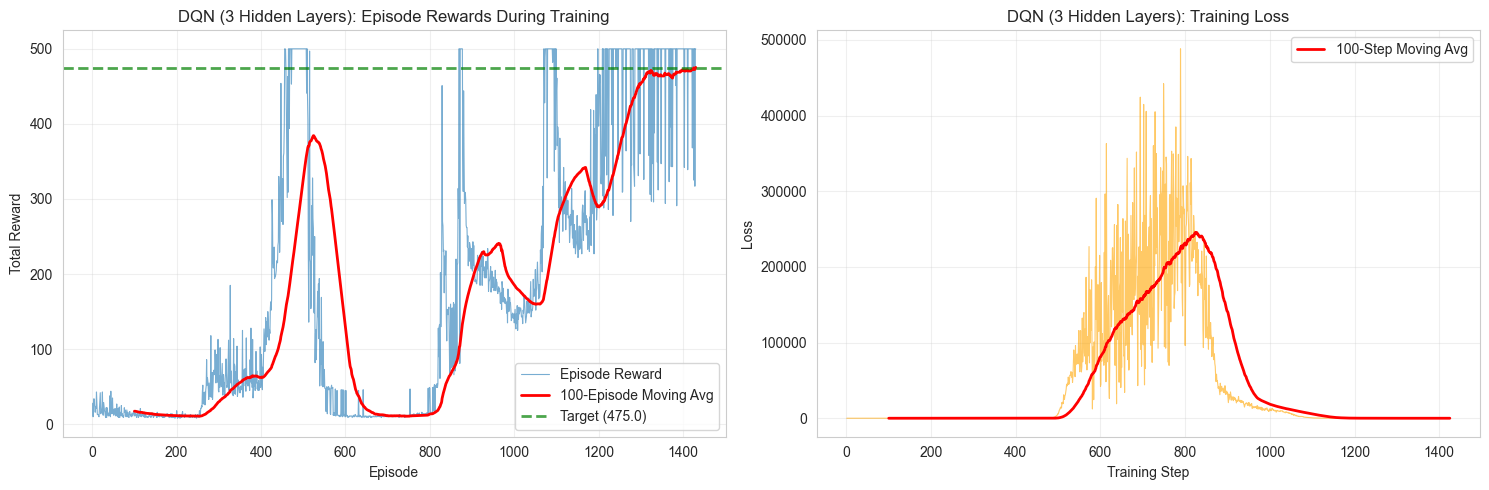

In [ ]:
# Print convergence information
print_convergence_info(results_3layers, "DQN (3 Hidden Layers)")

# Plot training metrics
plot_training_metrics(
    results_3layers, 
    "DQN (3 Hidden Layers)",
    save_path="results/section2/dqn_3layers_training.png"
)

### Test

Test the trained agent on new episodes.

In [23]:
# Test the agent
print("Testing trained agent...")
mean_reward, std_reward = agent_dqn_3layers.test_agent(
    env=env,
    num_episodes=100,
    render=False,
    max_steps=500
)

Testing trained agent...

Testing agent for 100 episodes...

Test Results:
Mean Reward (= Length): 490.02 ± 34.21


### Save Model

In [37]:
# Save the trained model and results
save_model_and_results(
    agent_dqn_3layers,
    results_3layers,
    "dqn_3layers"
)

Model saved to models\dqn_3layers_20251119_161622.pth
✓ Model saved to: models\dqn_3layers_20251119_161622.pth
✓ Results saved to: models\dqn_3layers_20251119_161622_results.npz


## 2.4: Configuration 2: 5 Hidden Layers

Now, we'll train a DQN agent with **5 hidden layers** of size [64, 64, 64, 64, 64].

### Train

In [24]:
# Configuration for DQN with 5 hidden layers - STABLE CONFIG
config_5_layers = {
    'hidden_dims': [128, 128, 128, 128, 128],
    'learning_rate': 0.000015,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_min': 0.0,
    'epsilon_decay': 0.9995,
    'batch_size': 128,
    'buffer_capacity': 50000,
    'target_update_freq': 100
}

# Create agent
agent_dqn_5layers = DeepQLearningAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    config=config_5_layers
)

print("DQN Agent Configuration (5 Hidden Layers):")
print(f"  Architecture: {config_5_layers['hidden_dims']}")
print(f"  Learning Rate: {config_5_layers['learning_rate']}")
print(f"  Discount Factor (γ): {config_5_layers['gamma']}")
print(f"  Epsilon Decay: {config_5_layers['epsilon_decay']}")
print(f"  Batch Size: {config_5_layers['batch_size']}")
print(f"  Replay Buffer Size: {config_5_layers['buffer_capacity']}")
print(f"  Target Update Frequency: {config_5_layers['target_update_freq']} steps")

Initialized DQN with 5 hidden layers: [128, 128, 128, 128, 128]
DQN Agent Configuration (5 Hidden Layers):
  Architecture: [128, 128, 128, 128, 128]
  Learning Rate: 1.5e-05
  Discount Factor (γ): 0.99
  Epsilon Decay: 0.9995
  Batch Size: 128
  Replay Buffer Size: 50000
  Target Update Frequency: 100 steps


In [36]:
print("Starting training with early stopping...")
print(f"Max episodes: {MAX_EPISODES} (will stop early if target reached)")
print(f"Target: {TARGET_REWARD} average reward over {TARGET_WINDOW} episodes")
print(f"Max steps per episode: {MAX_STEPS}")
print(f"Evaluation frequency: every {EVAL_FREQUENCY} episodes\n")

# Train the agent with early stopping
results_5layers = agent_dqn_5layers.train_agent(
    env=env,
    max_episodes=MAX_EPISODES,
    max_steps=MAX_STEPS,
    eval_frequency=EVAL_FREQUENCY,
    target_reward=TARGET_REWARD,
    target_window=TARGET_WINDOW,
    verbose=True
)

print("\n✓ Training completed!")
print(f"Episodes trained: {results_5layers['episodes_trained']}")
print(f"Converged: {'Yes ✓' if results_5layers['converged'] else 'No ✗'}")

Starting training with early stopping...
Max episodes: 10000 (will stop early if target reached)
Target: 475.0 average reward over 100 episodes
Max steps per episode: 500
Evaluation frequency: every 50 episodes

Episode 50/10000 | Avg Reward (=Length): 9.50 | Epsilon: 0.000
Episode 100/10000 | Avg Reward (=Length): 9.38 | Epsilon: 0.000
Episode 150/10000 | Avg Reward (=Length): 9.32 | Epsilon: 0.000
Episode 200/10000 | Avg Reward (=Length): 9.62 | Epsilon: 0.000
Episode 250/10000 | Avg Reward (=Length): 9.60 | Epsilon: 0.000
Episode 300/10000 | Avg Reward (=Length): 11.10 | Epsilon: 0.000
Episode 350/10000 | Avg Reward (=Length): 113.72 | Epsilon: 0.000
Episode 400/10000 | Avg Reward (=Length): 32.86 | Epsilon: 0.000
Episode 450/10000 | Avg Reward (=Length): 12.06 | Epsilon: 0.000
Episode 500/10000 | Avg Reward (=Length): 11.76 | Epsilon: 0.000
Episode 550/10000 | Avg Reward (=Length): 11.96 | Epsilon: 0.000
Episode 600/10000 | Avg Reward (=Length): 13.70 | Epsilon: 0.000
Episode 650/1

### Analize


CONVERGENCE ANALYSIS: DQN (5 Hidden Layers)
✗ Agent did not converge to 475.0 average within training
  Best 100-episode average achieved: 469.29

Figure saved to results/section2/dqn_5layers_training-2.png


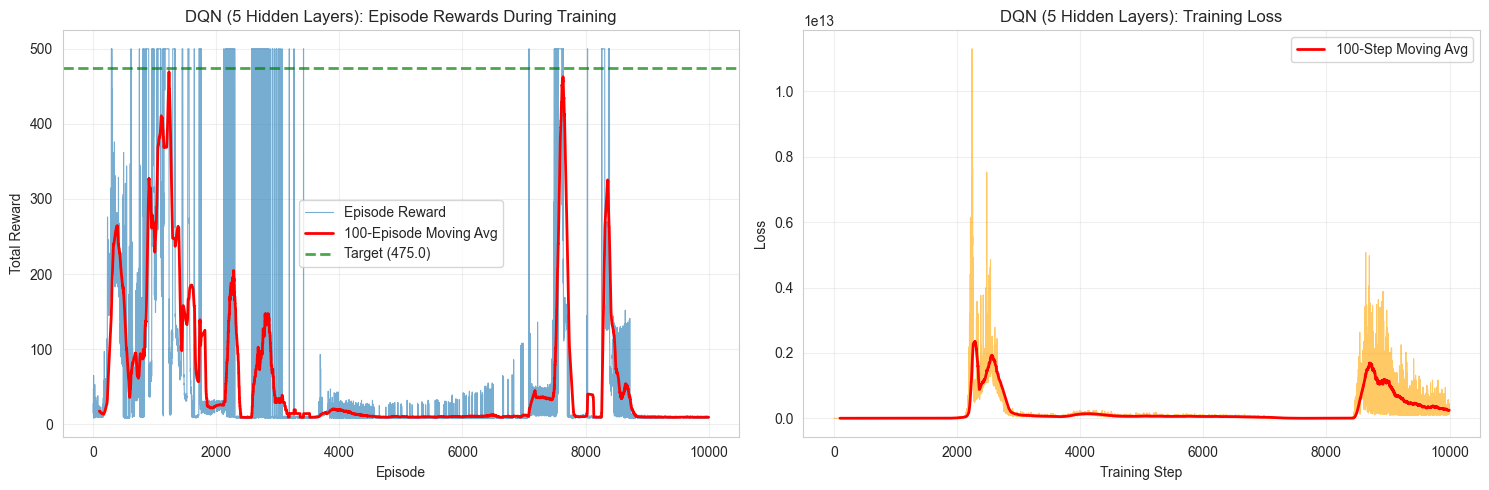

In [ ]:
# Print convergence information
print_convergence_info(results_5layers, "DQN (5 Hidden Layers)")

# Plot training metrics
plot_training_metrics(
    results_5layers, 
    "DQN (5 Hidden Layers)",
    save_path="results/section2/dqn_5layers_training.png"
)

### Test

In [27]:
# Test the agent
print("Testing trained agent...")
mean_reward, std_reward = agent_dqn_5layers.test_agent(
    env=env,
    num_episodes=100,
    render=False,
    max_steps=500
)

Testing trained agent...

Testing agent for 100 episodes...

Test Results:
Mean Reward (= Length): 9.47 ± 0.82


### Save Model

In [28]:
# Save the trained model and results
save_model_and_results(
    agent_dqn_5layers,
    results_5layers,
    "dqn_5layers"
)

Model saved to models\dqn_5layers_20251119_145126.pth
✓ Model saved to: models\dqn_5layers_20251119_145126.pth
✓ Results saved to: models\dqn_5layers_20251119_145126_results.npz


## 2.5: Compare 3-Layer vs 5-Layer Architectures

Compare the performance of both network architectures.

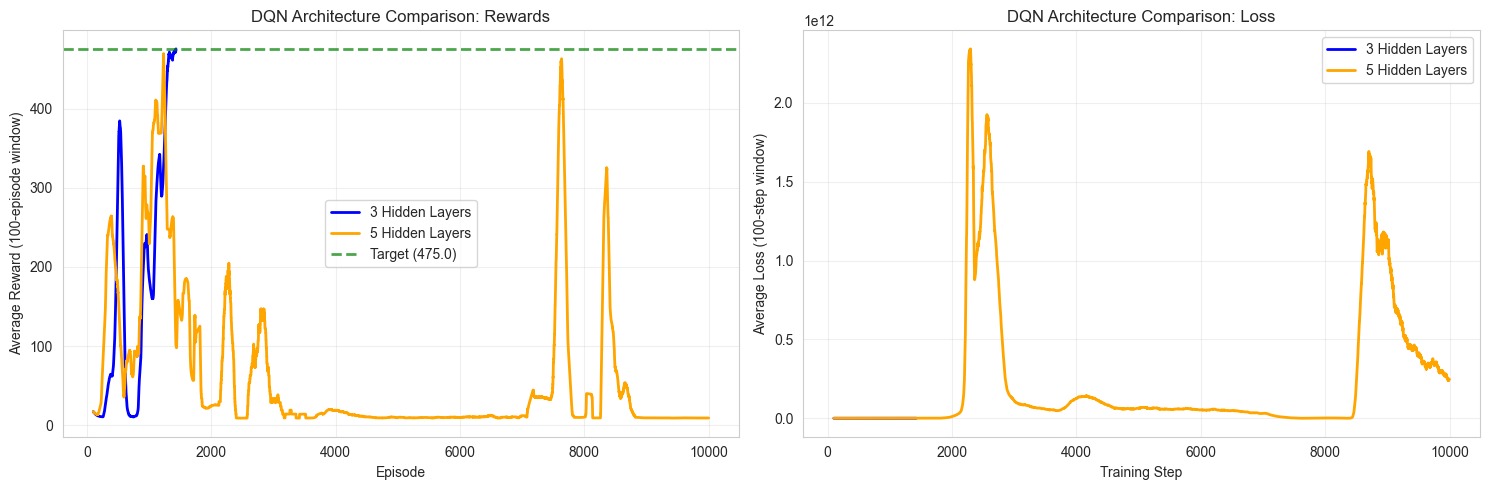


ARCHITECTURE COMPARISON SUMMARY

3 Hidden Layers:
  Convergence episode: 1430
  Final 100-ep avg: 475.28

5 Hidden Layers:
  Convergence episode: Not achieved
  Final 100-ep avg: 9.38



In [29]:
# Comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

window = 100

# Plot 1: Rewards comparison
for results, label, color in [(results_3layers, '3 Hidden Layers', 'blue'),
                               (results_5layers, '5 Hidden Layers', 'orange')]:
    episodes = np.arange(1, len(results['rewards']) + 1)
    
    # Moving average
    if len(results['rewards']) >= window:
        moving_avg = np.convolve(results['rewards'], np.ones(window)/window, mode='valid')
        axes[0].plot(np.arange(window, len(results['rewards']) + 1), moving_avg,
                    linewidth=2, label=label, color=color)

axes[0].axhline(y=475, color='green', linestyle='--', linewidth=2, 
               label='Target (475.0)', alpha=0.7)
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Average Reward (100-episode window)')
axes[0].set_title('DQN Architecture Comparison: Rewards')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss comparison
for results, label, color in [(results_3layers, '3 Hidden Layers', 'blue'),
                               (results_5layers, '5 Hidden Layers', 'orange')]:
    if len(results['losses']) >= window:
        loss_moving_avg = np.convolve(results['losses'], np.ones(window)/window, mode='valid')
        axes[1].plot(np.arange(window, len(results['losses']) + 1), loss_moving_avg,
                    linewidth=2, label=label, color=color)

axes[1].set_xlabel('Training Step')
axes[1].set_ylabel('Average Loss (100-step window)')
axes[1].set_title('DQN Architecture Comparison: Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results/section2/dqn_architecture_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Print comparison summary
print("\n" + "="*60)
print("ARCHITECTURE COMPARISON SUMMARY")
print("="*60)

conv_3 = find_convergence_episode(results_3layers['rewards'])
conv_5 = find_convergence_episode(results_5layers['rewards'])

print(f"\n3 Hidden Layers:")
print(f"  Convergence episode: {conv_3 if conv_3 > 0 else 'Not achieved'}")
print(f"  Final 100-ep avg: {np.mean(results_3layers['rewards'][-100:]):.2f}")

print(f"\n5 Hidden Layers:")
print(f"  Convergence episode: {conv_5 if conv_5 > 0 else 'Not achieved'}")
print(f"  Final 100-ep avg: {np.mean(results_5layers['rewards'][-100:]):.2f}")

print("\n" + "="*60)

---
# Section 3: Improved Deep Q-Learning Agent (Double DQN)

In this section, we implement and train an improved DQN agent with Double DQN enhancement.

## Double DQN Improvement:
- **Problem**: Standard DQN overestimates Q-values due to max operator bias
- **Solution**: Decouple action selection from action evaluation
  - Standard DQN: `y = r + γ max_a' Q_target(s', a')`
  - Double DQN: `y = r + γ Q_target(s', argmax_a' Q(s', a'))`

## Benefits:
- Reduces overestimation bias
- More stable and accurate Q-value estimates
- Often leads to better policies and faster convergence

## Optional Enhancement:
- Prioritized Experience Replay (can be enabled via config)
- Samples important transitions (high TD error) more frequently

---

## 3.1: Configure Double DQN Agent

We'll use the same architecture as the 3-layer DQN for fair comparison.

In [30]:
# Configuration for Double DQN (same as 3-layer DQN)
config_ddqn = {
    'hidden_dims': [128, 128, 128],
    'learning_rate': 0.000015,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_min': 0.00,
    'epsilon_decay': 0.9995,
    'batch_size': 128,
    'buffer_capacity': 50000,
    'target_update_freq': 100,
    
    # Improvements
    'use_double_dqn': True,          # Enable Double DQN
    'use_prioritized_replay': True  # Enable Priority Buffer
}

# Create improved agent
agent_ddqn = DoubleDeepQLearningAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    config=config_ddqn
)

print("Double DQN Agent Configuration:")
print(f"  Architecture: {config_ddqn['hidden_dims']}")
print(f"  Learning Rate: {config_ddqn['learning_rate']}")
print(f"  Double DQN: {'Enabled' if config_ddqn['use_double_dqn'] else 'Disabled'}")
print(f"  Prioritized Replay: {'Enabled' if config_ddqn['use_prioritized_replay'] else 'Disabled'}")
print(f"  Batch Size: {config_ddqn['batch_size']}")
print(f"  Replay Buffer: {config_ddqn['buffer_capacity']}")
print(f"  Target Update Freq: {config_ddqn['target_update_freq']} steps")

Initialized DQN with 3 hidden layers: [128, 128, 128]
Using Prioritized Experience Replay (α=0.6, β=0.4)
Double DQN Agent Configuration:
  Architecture: [128, 128, 128]
  Learning Rate: 1.5e-05
  Double DQN: Enabled
  Prioritized Replay: Enabled
  Batch Size: 128
  Replay Buffer: 50000
  Target Update Freq: 100 steps


## 3.2: Train Double DQN Agent

Train with the same parameters as Section 2 for fair comparison.

In [31]:
print("Starting Double DQN training with early stopping...")
print(f"Max episodes: {MAX_EPISODES}")
print(f"Target: {TARGET_REWARD} average reward over {TARGET_WINDOW} episodes\n")

# Train the agent
results_ddqn = agent_ddqn.train_agent(
    env=env,
    max_episodes=MAX_EPISODES,
    max_steps=MAX_STEPS,
    eval_frequency=EVAL_FREQUENCY,
    target_reward=TARGET_REWARD,
    target_window=TARGET_WINDOW,
    verbose=True
)

print("\n✓ Training completed!")
print(f"Episodes trained: {results_ddqn['episodes_trained']}")
print(f"Converged: {'Yes ✓' if results_ddqn['converged'] else 'No ✗'}")

Starting Double DQN training with early stopping...
Max episodes: 10000
Target: 475.0 average reward over 100 episodes

Episode 50/10000 | Avg Reward (=Length): 22.80 | Epsilon: 0.603
Episode 100/10000 | Avg Reward (=Length): 12.82 | Epsilon: 0.437
Episode 150/10000 | Avg Reward (=Length): 11.94 | Epsilon: 0.324
Episode 200/10000 | Avg Reward (=Length): 10.74 | Epsilon: 0.248
Episode 250/10000 | Avg Reward (=Length): 10.64 | Epsilon: 0.190
Episode 300/10000 | Avg Reward (=Length): 33.70 | Epsilon: 0.082
Episode 350/10000 | Avg Reward (=Length): 113.38 | Epsilon: 0.005
Episode 400/10000 | Avg Reward (=Length): 213.64 | Epsilon: 0.000
Episode 450/10000 | Avg Reward (=Length): 420.74 | Epsilon: 0.000
Episode 500/10000 | Avg Reward (=Length): 286.46 | Epsilon: 0.000
Episode 550/10000 | Avg Reward (=Length): 271.84 | Epsilon: 0.000
Episode 600/10000 | Avg Reward (=Length): 220.26 | Epsilon: 0.000
Episode 650/10000 | Avg Reward (=Length): 425.34 | Epsilon: 0.000
Episode 700/10000 | Avg Rewar

## 3.3: Analyze Training Results


CONVERGENCE ANALYSIS: Double DQN
✓ Agent converged at episode: 941
  (First episode where 100-episode average ≥ 475.0)

Final Performance (last 100 episodes):
  Average Reward: 475.63
  Max Reward: 500.00
  Min Reward: 129.00

Figure saved to results/section3/ddqn_training.png


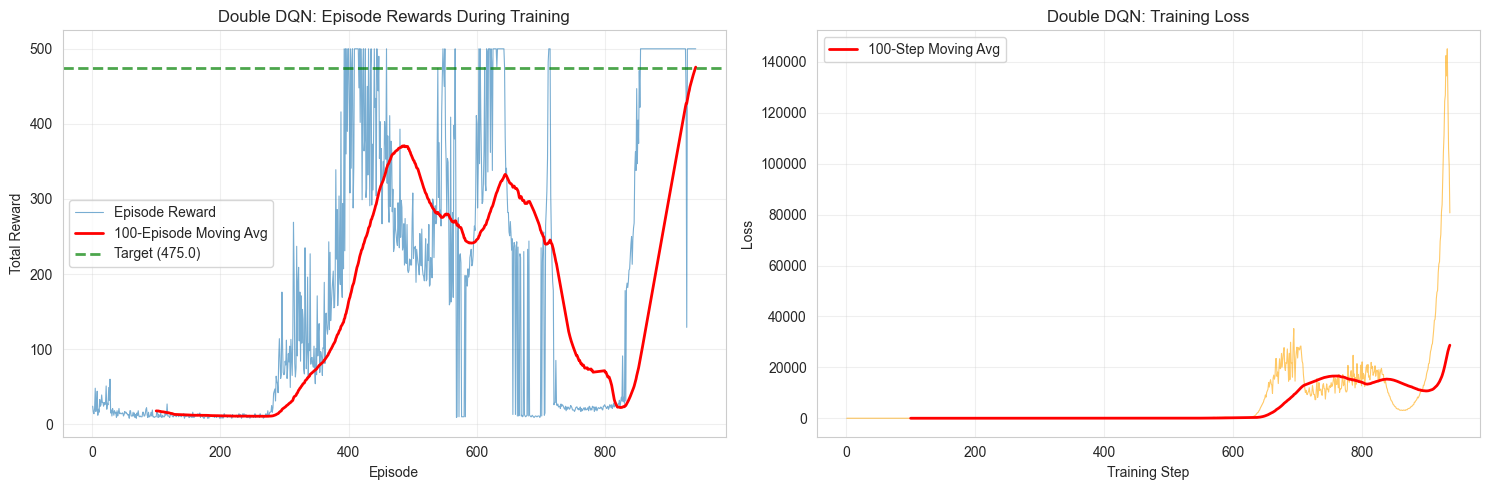

In [32]:
# Print convergence information
print_convergence_info(results_ddqn, "Double DQN")

# Plot training metrics
plot_training_metrics(
    results_ddqn, 
    "Double DQN",
    save_path="results/section3/ddqn_training.png"
)

## 3.4: Test Double DQN Agent

In [33]:
# Test the agent
print("Testing trained Double DQN agent...")
mean_reward_ddqn, std_reward_ddqn = agent_ddqn.test_agent(
    env=env,
    num_episodes=100,
    render=False,
    max_steps=500
)

Testing trained Double DQN agent...

Testing agent for 100 episodes...

Test Results:
Mean Reward (= Length): 500.00 ± 0.00


## 3.5: Save Model and Results

In [34]:
# Save the trained model and results
save_model_and_results(
    agent_ddqn,
    results_ddqn,
    "ddqn"
)

Model saved to models\ddqn_20251119_150600.pth
✓ Model saved to: models\ddqn_20251119_150600.pth
✓ Results saved to: models\ddqn_20251119_150600_results.npz


## 3.6: Compare Double DQN vs Standard DQN

Compare the improved agent against the standard 3-layer DQN from Section 2.

**Expected Results:**
- Double DQN should show **more stable** Q-value estimates
- May converge **faster** or achieve **higher** final performance
- Training curves should be **smoother** (less overestimation)

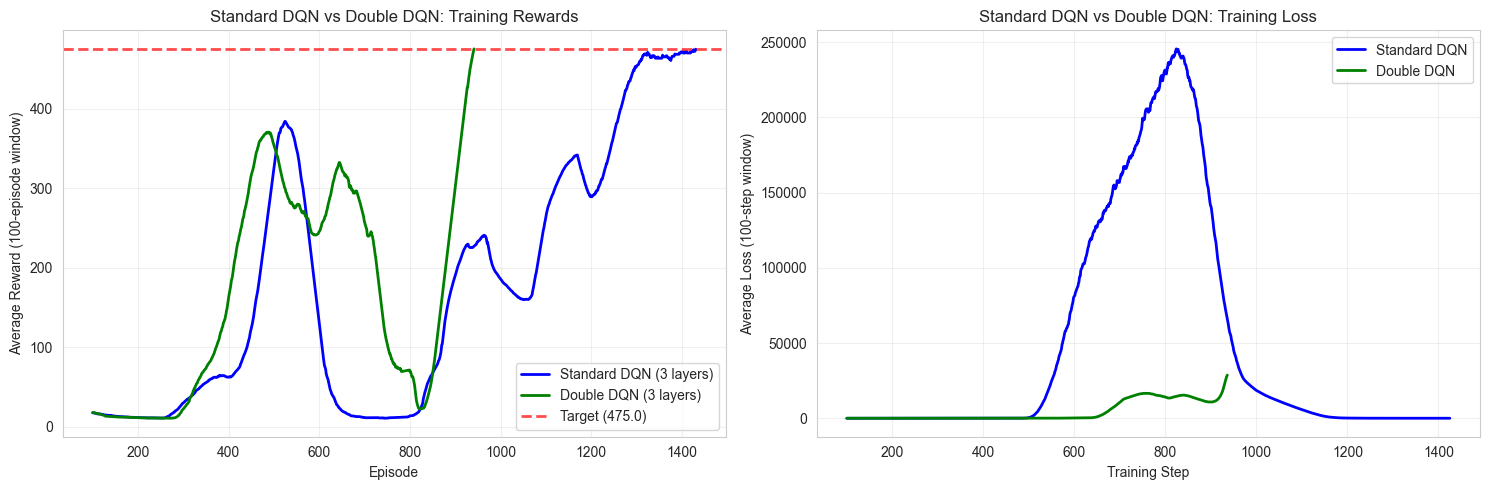


STANDARD DQN VS DOUBLE DQN COMPARISON

Standard DQN (3 layers):
  Convergence episode: 1430
  Final 100-ep avg: 475.28
  Total episodes: 1430

Double DQN (3 layers):
  Convergence episode: 941
  Final 100-ep avg: 475.63
  Total episodes: 941

Convergence Speed Improvement: +34.2%
✓ Double DQN converged 34.2% faster!
Final Performance Improvement: +0.07%

✓ Comparison plot saved to: results/section3/dqn_vs_ddqn_comparison.png


In [35]:
# Comparison plot: Double DQN vs Standard DQN
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

window = 100

# Plot 1: Rewards comparison
for results, label, color in [(results_3layers, 'Standard DQN (3 layers)', 'blue'),
                               (results_ddqn, 'Double DQN (3 layers)', 'green')]:
    episodes = np.arange(1, len(results['rewards']) + 1)
    
    # Moving average
    if len(results['rewards']) >= window:
        moving_avg = np.convolve(results['rewards'], np.ones(window)/window, mode='valid')
        axes[0].plot(np.arange(window, len(results['rewards']) + 1), moving_avg,
                    linewidth=2, label=label, color=color)

axes[0].axhline(y=475, color='red', linestyle='--', linewidth=2, 
               label='Target (475.0)', alpha=0.7)
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Average Reward (100-episode window)')
axes[0].set_title('Standard DQN vs Double DQN: Training Rewards')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss comparison
for results, label, color in [(results_3layers, 'Standard DQN', 'blue'),
                               (results_ddqn, 'Double DQN', 'green')]:
    if len(results['losses']) >= window:
        loss_moving_avg = np.convolve(results['losses'], np.ones(window)/window, mode='valid')
        axes[1].plot(np.arange(window, len(results['losses']) + 1), loss_moving_avg,
                    linewidth=2, label=label, color=color)

axes[1].set_xlabel('Training Step')
axes[1].set_ylabel('Average Loss (100-step window)')
axes[1].set_title('Standard DQN vs Double DQN: Training Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results/section3/dqn_vs_ddqn_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Print comparison summary
print("\n" + "="*70)
print("STANDARD DQN VS DOUBLE DQN COMPARISON")
print("="*70)

conv_standard = find_convergence_episode(results_3layers['rewards'])
conv_double = find_convergence_episode(results_ddqn['rewards'])

print(f"\nStandard DQN (3 layers):")
print(f"  Convergence episode: {conv_standard if conv_standard > 0 else 'Not achieved'}")
print(f"  Final 100-ep avg: {np.mean(results_3layers['rewards'][-100:]):.2f}")
print(f"  Total episodes: {results_3layers['episodes_trained']}")

print(f"\nDouble DQN (3 layers):")
print(f"  Convergence episode: {conv_double if conv_double > 0 else 'Not achieved'}")
print(f"  Final 100-ep avg: {np.mean(results_ddqn['rewards'][-100:]):.2f}")
print(f"  Total episodes: {results_ddqn['episodes_trained']}")

# Improvement analysis
if conv_standard > 0 and conv_double > 0:
    improvement = ((conv_standard - conv_double) / conv_standard) * 100
    print(f"\n{'='*70}")
    print(f"Convergence Speed Improvement: {improvement:+.1f}%")
    if improvement > 0:
        print(f"✓ Double DQN converged {abs(improvement):.1f}% faster!")
    elif improvement < 0:
        print(f"Standard DQN converged {abs(improvement):.1f}% faster.")
    else:
        print("Both converged at the same speed.")

final_perf_improvement = (np.mean(results_ddqn['rewards'][-100:]) - 
                          np.mean(results_3layers['rewards'][-100:])) / \
                         np.mean(results_3layers['rewards'][-100:]) * 100
print(f"Final Performance Improvement: {final_perf_improvement:+.2f}%")

print("="*70 + "\n")

print("✓ Comparison plot saved to: results/section3/dqn_vs_ddqn_comparison.png")